In [1]:
from nilearn.masking import compute_epi_mask, compute_brain_mask
from nilearn.image import load_img, mean_img, resample_to_img
from nilearn.plotting import plot_roi
from nilearn.masking import apply_mask
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask

/home/morteza/micromamba/envs/MultiModalRest/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


/home/morteza/micromamba/envs/MultiModalRest/lib/python3.10/site-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int16 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


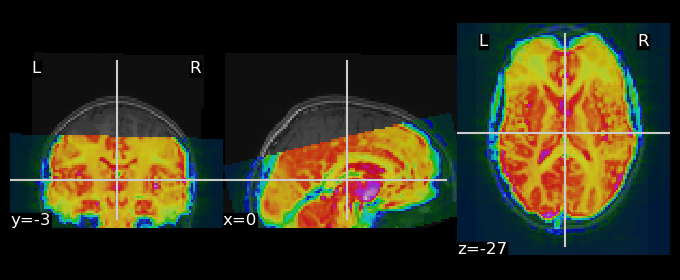

In [28]:
t2 = load_img('data/openneuro/ds004697/sub-001/ses-1/func/sub-001_ses-1_task-rest_bold.nii.gz')
t1 = load_img('data/openneuro/ds004697/sub-001/ses-1/anat/sub-001_ses-1_T1w.nii.gz')


# t2_mean = mean_img(t2)
# t1_mask = compute_brain_mask(t1)

mni152 = load_mni152_template(resolution=2)
from nilearn.image import resample_img

t1 = resample_to_img(t1, mni152)

# t1_mask = compute_brain_mask(t1)
# t1 = resample_to_img(t1, mni152)
# rs_img_mean = resample_to_img(rs_img_mean, mni152)

t2 = resample_to_img(t2, t1)
# t2 = resample_img(t2, mni152.affine, mni152.shape)
t2_mean = mean_img(t2)

# from nilearn.image import clean_img
# t2 = clean_img(t2, detrend=False, standardize=False, low_pass=None, high_pass=None, t_r=2)

plot_roi(t2_mean, t1)

In [29]:
import nibabel as nib

from dipy.align.transforms import AffineTransform3D
from dipy.align.imaffine import AffineRegistration
affreg = AffineRegistration()
t2_affine = affreg.optimize(mni152.get_fdata(), t2_mean.get_fdata(), AffineTransform3D(), params0=None)
t1_reg = nib.Nifti1Image(t2_affine.transform(t2_mean.get_fdata()),
                         t2.affine, t2.header)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


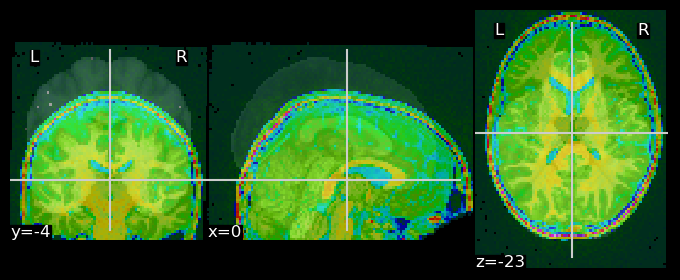

In [46]:
t2_mean_1 = resample_img(t2_mean, mni152.affine, mni152.shape)
t1_1 = resample_img(t1, mni152.affine, mni152.shape)
plot_roi(t1_1, mni152)

In [74]:
t2_mean.affine, t1.affine, mni152.affine

(array([[   2.,    0.,    0.,  -98.],
        [   0.,    2.,    0., -134.],
        [   0.,    0.,    2.,  -72.],
        [   0.,    0.,    0.,    1.]]),
 array([[   2.,    0.,    0.,  -98.],
        [   0.,    2.,    0., -134.],
        [   0.,    0.,    2.,  -72.],
        [   0.,    0.,    0.,    1.]]),
 array([[   2.,    0.,    0.,  -98.],
        [   0.,    2.,    0., -134.],
        [   0.,    0.,    2.,  -72.],
        [   0.,    0.,    0.,    1.]]))

Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 3s 3s/step
Brain extraction:  renormalize probability mask to native space.


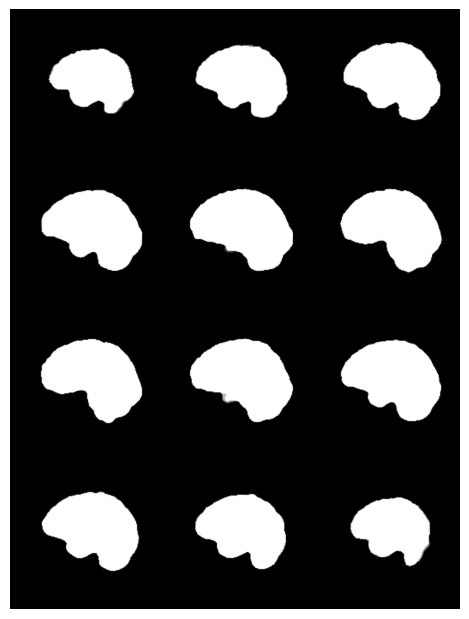

In [18]:
# ANTS

import ants


t1 = ants.image_read('data/openneuro/ds004697/sub-001/ses-1/anat/sub-001_ses-1_T1w.nii.gz')
t2 = ants.image_read('data/openneuro/ds004697/sub-001/ses-1/func/sub-001_ses-1_task-rest_bold.nii.gz')

import antspynet

t1_prob_brain_mask = antspynet.brain_extraction(t1, modality='t1', verbose=True)
t1_prob_brain_mask.plot()

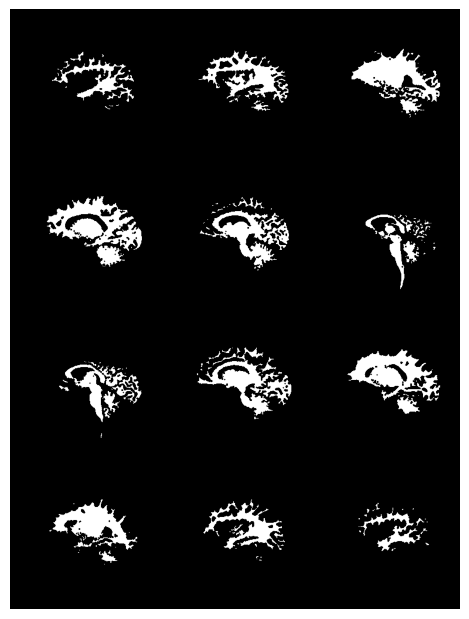

In [19]:
# t2_reg = ants.registration(t1, t2, type_of_transform='SyNBold')
# use anytspy to extract brain from t1

def brain_extract(img):
    bm_img = ants.threshold_image(img, "Otsu", 3 )
    bm_img = ants.threshold_image( bm_img,  2, 3 )
    bm_img = ants.iMath(bm_img, "ME", 1)
    bm_img = ants.iMath(bm_img, "GetLargestComponent")
    bm_img = ants.iMath(bm_img, "MD", 1)
    bm_img = ants.iMath(bm_img, "ME", 1)
    return bm_img

t1_brain = brain_extract(t1)

t1_brain.plot()